# Dfsu - Speed and direction

In [1]:
import numpy as np
from mikeio import Dfsu

filename = "../tests/testdata/HD2D.dfsu"
dfs = Dfsu(filename)
dfs

Dfsu2D
Number of elements: 884
Number of nodes: 529
Projection: UTM-29
Items:
  0:  Surface elevation &lt;Surface Elevation&gt; (meter)
  1:  U velocity &lt;u velocity component&gt; (meter per sec)
  2:  V velocity &lt;v velocity component&gt; (meter per sec)
  3:  Current speed &lt;Current Speed&gt; (meter per sec)
Time: 9 steps with dt=9000.0s
      1985-08-06 07:00:00 -- 1985-08-07 03:00:00

This file is missing current direction :-(

Lets'fix that!

In [2]:
ds = dfs.read()
ds

&lt;mikeio.DataSet&gt;
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Surface elevation &lt;Surface Elevation&gt; (meter)
  1:  U velocity &lt;u velocity component&gt; (meter per sec)
  2:  V velocity &lt;v velocity component&gt; (meter per sec)
  3:  Current speed &lt;Current Speed&gt; (meter per sec)

## Calculate speed & direction

In [3]:
u = ds["U velocity"]
v = ds["V velocity"]

In [4]:
direction = np.mod(90 -np.rad2deg(np.arctan2(v,u)),360)
speed = np.sqrt(u**2+v**2)

## Write new file

In [5]:
from mikeio.eum import ItemInfo, EUMType, EUMUnit
from mikeio import Dataset
data = [speed, direction]

items = [ItemInfo(EUMType.Current_Speed),
         ItemInfo("Current direction", EUMType.Current_Direction, EUMUnit.degree)] # default unit is radians

newds = Dataset(data,ds.time,items)
newds

&lt;mikeio.DataSet&gt;
Dimensions: (9, 884)
Time: 1985-08-06 07:00:00 - 1985-08-07 03:00:00
Items:
  0:  Current Speed &lt;Current Speed&gt; (meter per sec)
  1:  Current direction &lt;Current Direction&gt; (degree)

In [6]:
dfs.write("speed_direction.dfsu", newds)

In [7]:
ndfs = Dfsu("speed_direction.dfsu")
ndfs

Dfsu2D
Number of elements: 884
Number of nodes: 529
Projection: UTM-29
Items:
  0:  Current Speed &lt;Current Speed&gt; (meter per sec)
  1:  Current direction &lt;Current Direction&gt; (degree)
Time: 9 steps with dt=9000.0s
      1985-08-06 07:00:00 -- 1985-08-07 03:00:00

# Plot

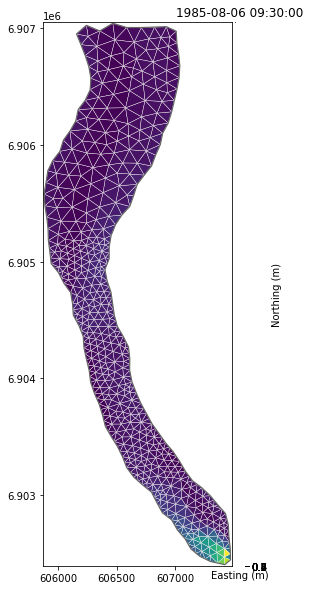

In [8]:
import matplotlib.pyplot as plt

ts = 1

cs = ds["Current speed"][ts]
u = ds["U velocity"][ts]
v = ds["V velocity"][ts]
ec = dfs.element_coordinates
x = ec[:,0]
y = ec[:,1]
dfs.plot(cs, label="Current speed (m/s)")
plt.quiver(x, y, u, v, headwidth=8)
ax  = plt.gca()
ax.set_ylim([None,6903000])
ax.set_xlim([607000,None])
ax.set_title(ds.time[ts])
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")

fig = plt.gcf()
fig.set_size_inches(10,10)

## Clean up

In [9]:
import os

os.remove("speed_direction.dfsu")